Random Seeding & Enable Determinism to produce replicable results

In [1]:
import tensorflow as tf
from tensorflow import keras

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

2024-06-26 12:09:31.189269: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 12:09:31.206156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 12:09:31.206169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 12:09:31.206747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 12:09:31.209986: I tensorflow/core/platform/cpu_feature_guar

Importing libraries and modules

In [2]:
import numpy as np
import pandas as pd
import sklearn
import time
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from keras import layers
from keras.models import Sequential
from keras.layers import GRU, Dense
from pickle import dump
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(tf.__version__) 

2.15.0


In [3]:
features = ["Neck_right-ward_rotation", "LeftElbow_flexion", "RightElbow_flexion", "LeftKnee_flexion", "RightKnee_flexion", "Thorax_extension", "Thorax_lateral_flexion_rotation"]

Load Dataset

In [4]:
train_df = pd.read_csv("/home/RUS_CIP/st179677/project/dataset/5 users/60 FPS - clipped/train.csv")
train_labels = train_df["label"]
train_df = train_df[features]

test_df = pd.read_csv("/home/RUS_CIP/st179677/project/dataset/5 users/60 FPS - clipped/test.csv")
test_labels = test_df["label"]
test_df = test_df[features]

train_df

,Neck_right-ward_rotation,LeftElbow_flexion,RightElbow_flexion,LeftKnee_flexion,RightKnee_flexion,Thorax_extension,Thorax_lateral_flexion_rotation
0,3.549500,3.371736,6.512918,-0.027976,-9.991233,4.250910,1.359221
1,3.535295,3.384024,6.488364,-0.044235,-10.002430,4.234431,1.358340
2,3.520810,3.393730,6.458497,0.000000,-10.025780,4.219234,1.354973
3,3.515579,3.396440,6.445703,0.000000,-10.041360,4.213845,1.352576
4,3.502299,3.399379,6.424006,0.000000,-10.073370,4.209521,1.349454
...,...,...,...,...,...,...,...
37822,-7.042944,19.845620,2.196420,-25.599820,-15.201360,-5.448487,-4.488398
37823,-7.032102,16.464140,1.834937,-25.603310,-14.568030,-5.302969,-4.015072
37824,-6.960776,10.478350,1.033061,-25.585250,-13.215460,-5.018915,-3.140173
37825,-6.853118,5.816689,-0.027976,-25.631230,-11.444740,-4.787452,-2.385553


In [5]:
test_df

,Neck_right-ward_rotation,LeftElbow_flexion,RightElbow_flexion,LeftKnee_flexion,RightKnee_flexion,Thorax_extension,Thorax_lateral_flexion_rotation
0,2.765412,20.814490,30.12619,-8.229175,-13.131230,6.504000,1.627866
1,2.636559,21.221590,30.88624,-8.038465,-12.906960,6.463595,1.625073
2,2.508973,21.468310,31.50667,-7.943271,-12.765620,6.425258,1.627737
3,2.449764,21.518730,31.76913,-7.920478,-12.722180,6.405085,1.628181
4,2.332213,21.480970,32.18284,-7.882718,-12.654570,6.368090,1.629171
...,...,...,...,...,...,...,...
9577,4.687718,6.453425,10.98043,-22.254830,-5.575275,2.471084,-1.660658
9578,4.459927,7.567453,11.02977,-22.112130,-4.936616,2.437349,-1.303692
9579,4.323501,8.213532,11.07498,-22.051290,-4.675375,2.496616,-1.127473
9580,4.081591,9.373895,11.12502,-21.856070,-4.978978,2.689409,-0.686530


Scaling the dataset

In [6]:
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns = train_df.columns, index=train_df.index)

# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))
test_df = pd.DataFrame(scaler.transform(test_df), columns = test_df.columns, index=test_df.index)

train_df

,Neck_right-ward_rotation,LeftElbow_flexion,RightElbow_flexion,LeftKnee_flexion,RightKnee_flexion,Thorax_extension,Thorax_lateral_flexion_rotation
0,0.017396,-0.930361,-0.716564,0.822575,0.576255,0.610628,0.473599
1,0.016010,-0.929954,-0.717281,0.822009,0.575842,0.609845,0.473469
2,0.014597,-0.929633,-0.718154,0.823549,0.574979,0.609123,0.472970
3,0.014087,-0.929543,-0.718527,0.823549,0.574404,0.608867,0.472616
4,0.012791,-0.929445,-0.719161,0.823549,0.573222,0.608661,0.472154
...,...,...,...,...,...,...,...
37822,-1.015844,-0.384439,-0.842628,-0.067633,0.383842,0.149849,-0.391882
37823,-1.014786,-0.496497,-0.853185,-0.067755,0.407231,0.156762,-0.321827
37824,-1.007829,-0.694858,-0.876604,-0.067126,0.457183,0.170257,-0.192337
37825,-0.997327,-0.849339,-0.907591,-0.068727,0.522576,0.181252,-0.080649


In [7]:
# Create 51 empty lists with names X0 to X50
X0, X1, X2, X3, X4, X5, X6, x0, x1, x2, x3, x4, x5, x6, y_train, y_test = ([] for _ in range(16))

Create Sequences from Dataset

In [8]:
timesteps = 60
step_size = 1  # Adjust this value as needed to control the overlap

"""TRAIN DATA"""
# Iterate over the range of rows in df
for i in range(0, train_df.shape[0] - timesteps):
    for j in range(7):  # Loop for column indexing
        globals()[f'X{j}'].append(train_df.iloc[i:i + timesteps, j])


# Iterate over the range of rows in labels_df
for i in range(0, train_labels.shape[0] - timesteps):
    y_train.append(train_labels.iloc[i + timesteps])

"""TEST DATA"""
# Iterate over the range of rows in df
for i in range(0, test_df.shape[0] - timesteps):
    for j in range(7):  # Loop for column indexing
        globals()[f'x{j}'].append(test_df.iloc[i:i + timesteps, j])


# Iterate over the range of rows in labels_df
for i in range(0, test_labels.shape[0] - timesteps):
     y_test.append(test_labels.iloc[i + timesteps])


In [9]:
type(y_train), type(y_test)
len(y_train), len(y_test)

(37767, 9522)

In [10]:
X0, X1, X2, X3, X4, X5, X6, x0, x1, x2, x3, x4, x5, x6, y_train, y_test = np.array(X0), np.array(X1),  np.array(X2),  np.array(X3),  np.array(X4),  np.array(X5),  np.array(X6), np.array(x0), np.array(x1),  np.array(x2),  np.array(x3),  np.array(x4),  np.array(x5),  np.array(x6),  np.array(y_train), np.array(y_test)

In [11]:
X0.shape, x0.shape

# X0 = scaler.fit_transform(X0)

((37767, 60), (9522, 60))

In [12]:
X0

array([[ 0.01739563,  0.01601   ,  0.01459707, ...,  0.0108171 ,
         0.00923931,  0.00814652],
       [ 0.01601   ,  0.01459707,  0.01408681, ...,  0.00923931,
         0.00814652,  0.00535985],
       [ 0.01459707,  0.01408681,  0.01279141, ...,  0.00814652,
         0.00535985,  0.00254978],
       ...,
       [ 0.84678727,  0.84285816,  0.81871773, ..., -1.00492814,
        -1.0158439 , -1.01478632],
       [ 0.84285816,  0.81871773,  0.79589318, ..., -1.0158439 ,
        -1.01478632, -1.00782883],
       [ 0.81871773,  0.79589318,  0.73137109, ..., -1.01478632,
        -1.00782883, -0.99732733]])

In [13]:
X_train = np.stack([X0, X1, X2, X3, X4, X5, X6], axis=2)
X_test = np.stack([x0, x1, x2, x3, x4, x5, x6], axis=2)
print(X_train.shape, X_test.shape)

(37767, 60, 7) (9522, 60, 7)


In [14]:
# # convert labels to one hot encoded

# encoder = LabelEncoder()
# encoder.fit(y)
# encoded_Y = encoder.transform(y)

# # encode integers to one hot encoded values
# Y = to_categorical(encoded_Y)
# print(Y)
# print(Y.shape)

Train-test-validation split

In [15]:
#splitting dataset into train, test and validation
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2, stratify=y_train)

print("X train :",X_train.shape)
print("y train:", Y_train.shape)
print("X test :", X_test.shape)
print("y test :" ,y_test.shape)
print("X val :" ,X_val.shape)
print("y val :" ,Y_val.shape)

"""CHECK CLASS DISTRIBUTION"""
unique, counts = np.unique(Y_train, return_counts=True)
# unique, counts = np.unique(y_test, return_counts=True)
# unique, counts = np.unique(Y_val, return_counts=True)

dict(zip(unique, counts))


X train : (33990, 60, 7)
y train: (33990,)
X test : (9522, 60, 7)
y test : (9522,)
X val : (3777, 60, 7)
y val : (3777,)


{0: 8716, 1: 6758, 2: 6420, 3: 5906, 4: 6190}

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
import time

NAME = "GRU-model-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

filepath_1 = '/home/RUS_CIP/st179677/project/model/models/gru_best_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath_1, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

callbacks_list = [early_stopping, tensorboard]

In [17]:
#GRU Model
# 
gru_model = Sequential()
gru_model.add(layers.GRU(16, input_shape=(60,7)))
gru_model.add(Dense(16, activation='relu'))
gru_model.add(Dense(5, activation='softmax'))
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                1200      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1557 (6.08 KB)
Trainable params: 1557 (6.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-06-26 12:09:46.214581: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-06-26 12:09:46.214608: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: ias-1316
2024-06-26 12:09:46.214613: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: ias-1316
2024-06-26 12:09:46.214715: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-06-26 12:09:46.214730: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-06-26 12:09:46.214734: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.171.4 does not match DSO version 535.183.1 -- cannot find working devices in this configuration


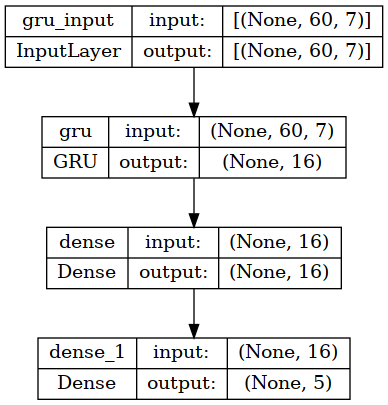

In [18]:
from keras.utils import plot_model
plot_model(gru_model,show_shapes= True, show_layer_names= True, to_file='/home/RUS_CIP/st179677/project/model/GRU.png')

In [19]:
#GRU model
from keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)
# chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
gru_history=gru_model.fit(X_train, Y_train ,validation_data=([X_val], Y_val), epochs=200, batch_size=32, callbacks=callbacks_list)

Epoch 1/200
1063/1063 [==============================] - 9s 8ms/step - loss: 1.1478 - accuracy: 0.6384 - val_loss: 0.7619 - val_accuracy: 0.7556
Epoch 2/200
1063/1063 [==============================] - 8s 7ms/step - loss: 0.5825 - accuracy: 0.8109 - val_loss: 0.4601 - val_accuracy: 0.8605
Epoch 3/200
1063/1063 [==============================] - 8s 7ms/step - loss: 0.3559 - accuracy: 0.8934 - val_loss: 0.2737 - val_accuracy: 0.9222
Epoch 4/200
1063/1063 [==============================] - 8s 7ms/step - loss: 0.2163 - accuracy: 0.9422 - val_loss: 0.1858 - val_accuracy: 0.9542
Epoch 5/200
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1593 - accuracy: 0.9589 - val_loss: 0.1554 - val_accuracy: 0.9584
Epoch 6/200
1063/1063 [==============================] - 7s 7ms/step - loss: 0.1347 - accuracy: 0.9640 - val_loss: 0.1375 - val_accuracy: 0.9637
Epoch 7/200
1063/1063 [==============================] - 8s 7ms/step - loss: 0.1206 - accuracy: 0.9684 - val_loss: 0.1247 - val_ac

In [20]:
# %tensorboard --logdir='logs/'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


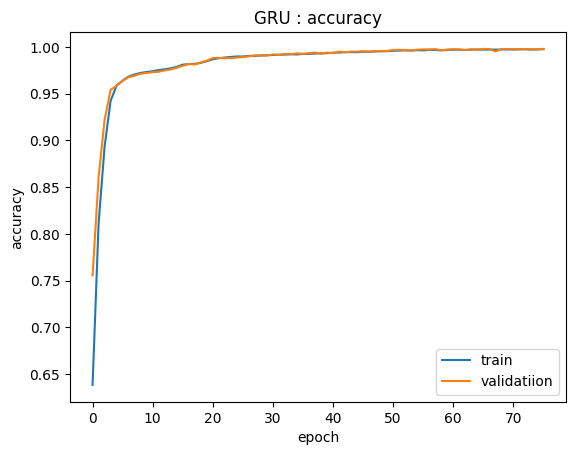

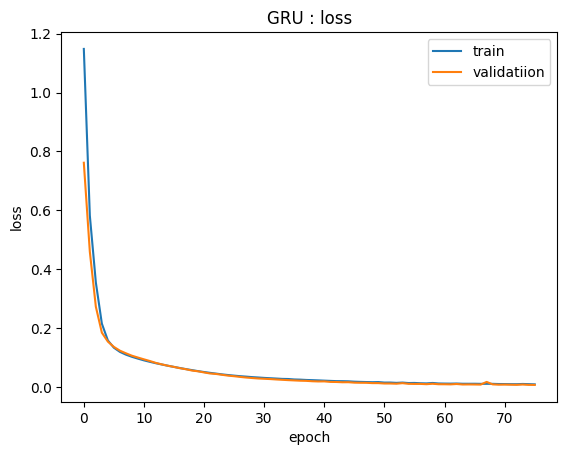

In [21]:
# list all data in history
print(gru_history.history.keys())

# summarize history for accuracy
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('GRU : accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validatiion'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('GRU : loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validatiion'], loc='upper right')
plt.show()

In [22]:
#predicting on test datset
from keras.models import load_model
from sklearn.metrics import accuracy_score
# model = load_model(model_filepath)
start_time = time.time()
gru_classify_x=gru_model.predict(X_test)
end_time = time.time() - start_time
print(f"Inference time = {end_time}")
# print(classify_x)
gru_classes_x=np.argmax(gru_classify_x,axis=1)
# y_test= np.argmax(y_test,axis=1)
print(gru_classes_x)
accuracy = accuracy_score(y_test, gru_classes_x)
accuracy

298/298 [==============================] - 1s 2ms/step
Inference time = 0.8098123073577881
[4 4 4 ... 4 4 4]


0.96040747742071

Classification Metrics

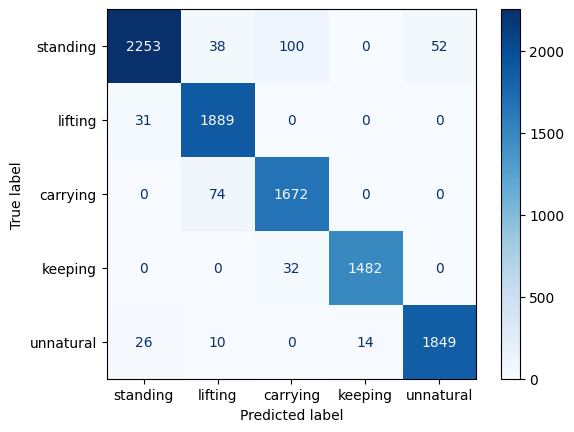

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2443
           1       0.94      0.98      0.96      1920
           2       0.93      0.96      0.94      1746
           3       0.99      0.98      0.98      1514
           4       0.97      0.97      0.97      1899

    accuracy                           0.96      9522
   macro avg       0.96      0.96      0.96      9522
weighted avg       0.96      0.96      0.96      9522



In [23]:
labels = ["standing", "lifting", "carrying", "keeping", "unnatural"]

cm = confusion_matrix(y_test, gru_classes_x)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, gru_classes_x))

Save Model File

In [24]:
model_filepath=f'/home/RUS_CIP/st179677/project/model/{round(accuracy*100,2)}_gru.h5'

gru_model.save(model_filepath)
gru_model.save(model_filepath, save_format='h5')

/home/RUS_CIP/st179677/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
